In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

### Main Features Analysis

In [3]:
df = pd.read_csv('data/wine.csv')
df = pd.get_dummies(df,drop_first=True)

df.corr()['type_white'].sort_values(ascending=False)
#volatile acidity
#total sulfur dioxide

type_white              1.000000
total sulfur dioxide    0.700357
free sulfur dioxide     0.471644
residual sugar          0.348821
citric acid             0.187397
quality                 0.119323
alcohol                 0.032970
pH                     -0.329129
density                -0.390645
fixed acidity          -0.486740
sulphates              -0.487218
chlorides              -0.512678
volatile acidity       -0.653036
Name: type_white, dtype: float64

d:\Documents\sigmoid_assignments\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


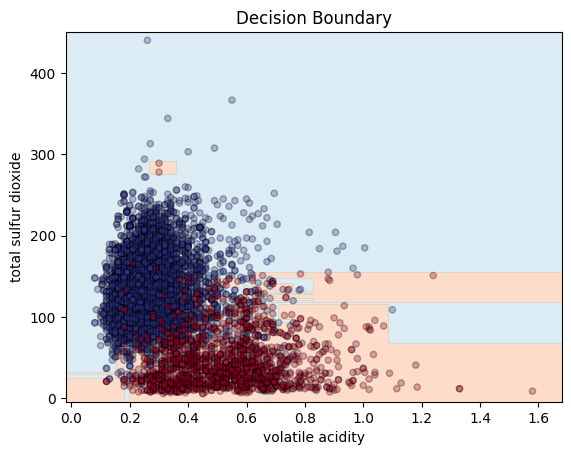

In [4]:
#2 main features
X = df[['volatile acidity', 'total sulfur dioxide']]
y = df['type_white']

model = DecisionTreeClassifier(random_state=42).fit(X, y)

# Create mesh grid
x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
y_min, y_max = X.iloc[:, 1].min() - 10, X.iloc[:, 1].max() + 10
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on mesh
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='RdYlBu', edgecolors='k', s=20,alpha=0.3)
plt.xlabel('volatile acidity')
plt.ylabel('total sulfur dioxide')
plt.title('Decision Boundary')
plt.show()

As seen in the plot, the decision boundary has clear discrete splits which delimit the white and red wines by the 2 features. Similarly, the areas on which points overlap the decision boundary is attributed to most popular class.
There are 2 points that falsely create a boundary within the space that is mostly populated by the other type of wine which would cause the model to overfit for that specific segment.

### Baseline Model


In [5]:

X = df.drop('type_white', axis=1)
y = df['type_white']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hyperparameters =  {
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'min_weight_fraction_leaf': 0.0,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0
}

model = DecisionTreeClassifier(random_state=42, **hyperparameters).fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train))
test_score = accuracy_score(y_test, model.predict(X_test))

print(f"Train Accuracy: {train_score:.4f} --- Test Accuracy: {test_score:.4f}")


Train Accuracy: 0.9883 --- Test Accuracy: 0.9831


### Manual Hyperparameter Tuning


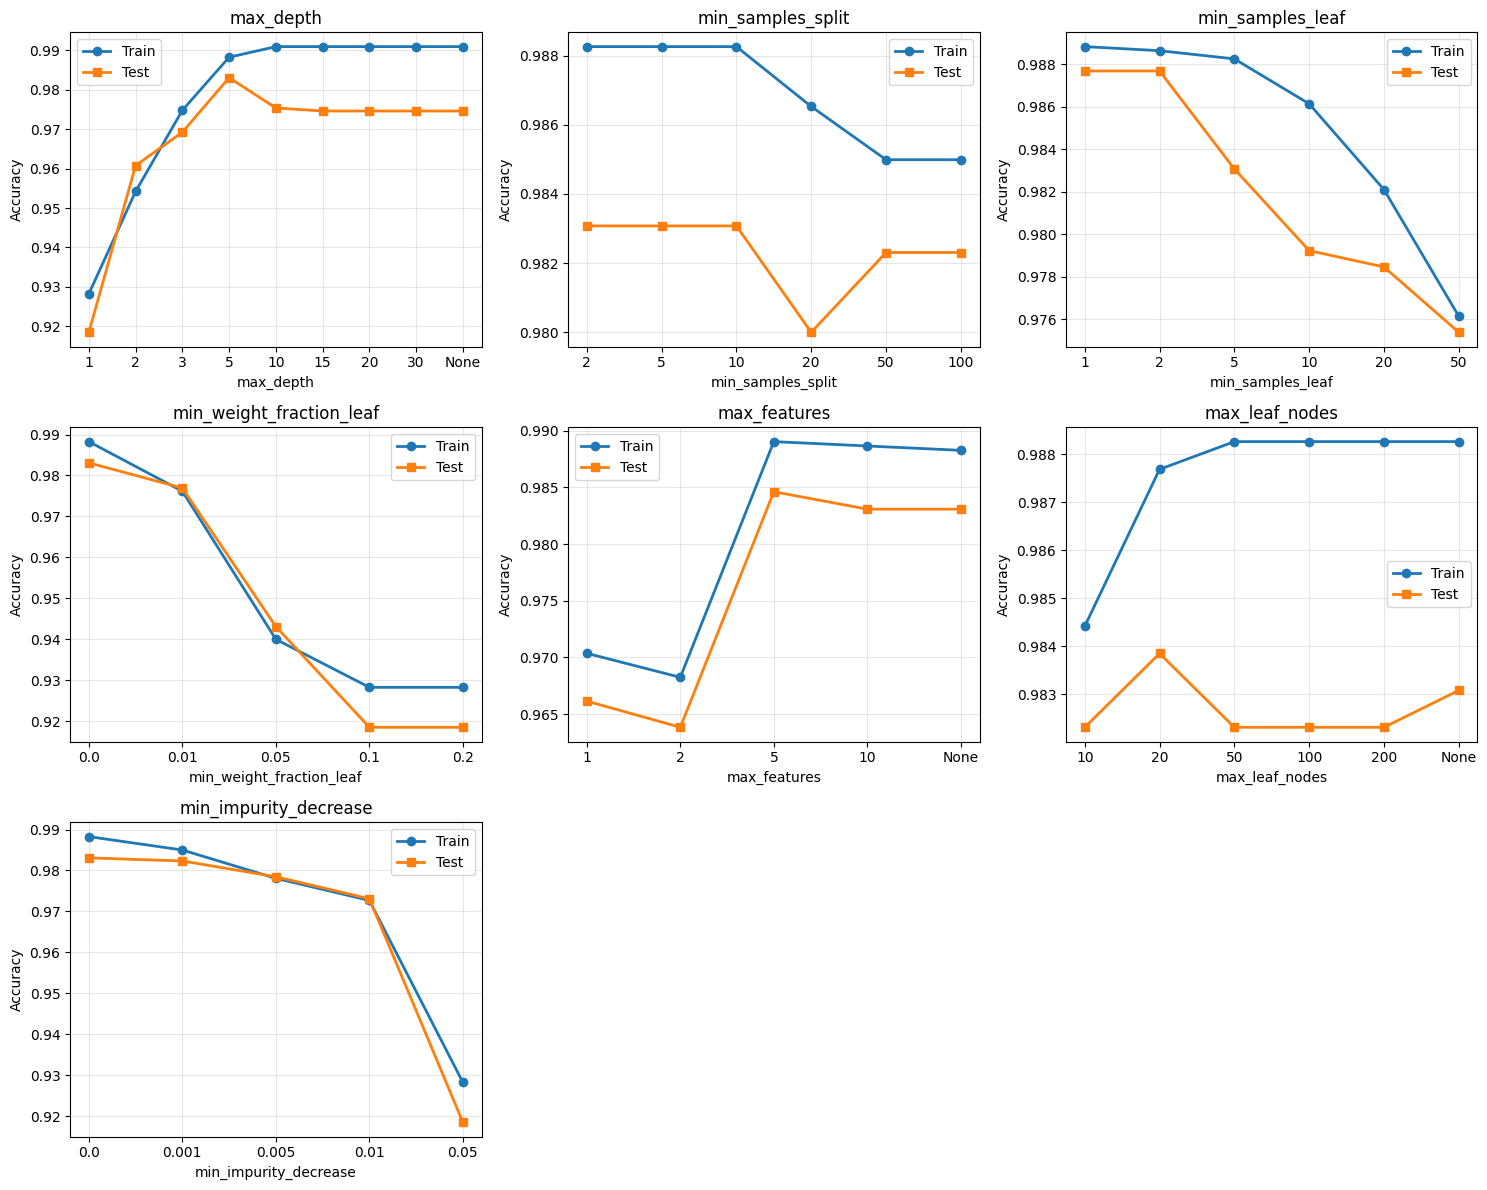

In [6]:

param_ranges = {
    'max_depth': [1, 2, 3, 5, 10, 15, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 2, 5, 10, 20, 50],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05, 0.1, 0.2],
    'max_features': [1, 2, 5, 10, None],
    'max_leaf_nodes': [10, 20, 50, 100, 200, None],
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.05]
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, (param_name, param_values) in enumerate(param_ranges.items()):
    train_scores = []
    test_scores = []
    
    for value in param_values:
        '''
        Creates a model with all the values in hyperparameters except 
        the one tested which is taken from a loop over param_ranges
        '''
        params = hyperparameters.copy()
        params[param_name] = value
        
        model = DecisionTreeClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        
        train_scores.append(accuracy_score(y_train, model.predict(X_train)))
        test_scores.append(accuracy_score(y_test, model.predict(X_test)))
    
    # Plot
    x_labels = [str(v) for v in param_values]
    x_pos = range(len(param_values))
    
    axes[idx].plot(x_pos, train_scores, 'o-', label='Train', linewidth=2)
    axes[idx].plot(x_pos, test_scores, 's-', label='Test', linewidth=2)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(x_labels)
    axes[idx].set_xlabel(param_name)
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'{param_name}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Remove extra subplots
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

plt.tight_layout()
plt.show()

#### Hyperparameter Importance

- For the max depth parameter, under 5 the model underfits and over 5 the model overfits with 5 being the optimal depth.
- The minimum sample split parameter controls the granularity of the model with a high sample size reducing overfitting while mmore granular splits will cause it to overfit, 10 is the optimal value.
- Minimum leaf node samples prevents having insignificant leaves that encompass noise, in our case the optimal value is 2 that slightly reduces overfitting, anything over that loses quality data.
- Similar to the previous one this is shows min_samples_leaf but as a fraction of total samples, optimal value = 0.
- Max features randomly selects n number of features at each split, underfits before 5, overfits after 5.
- Similar to minimum leaf node samples this allows us to control the maximum amount of leaves or predictions to avoid overfitting/underfitting, optimal value = 20
- Allows to select splits based on the minimum amount of information gain, 0 allows all splits and retains most information thus best accuracy. Although 0.001 overfits less.

Train Accuracy: 0.9813 --- Test Accuracy: 0.9862


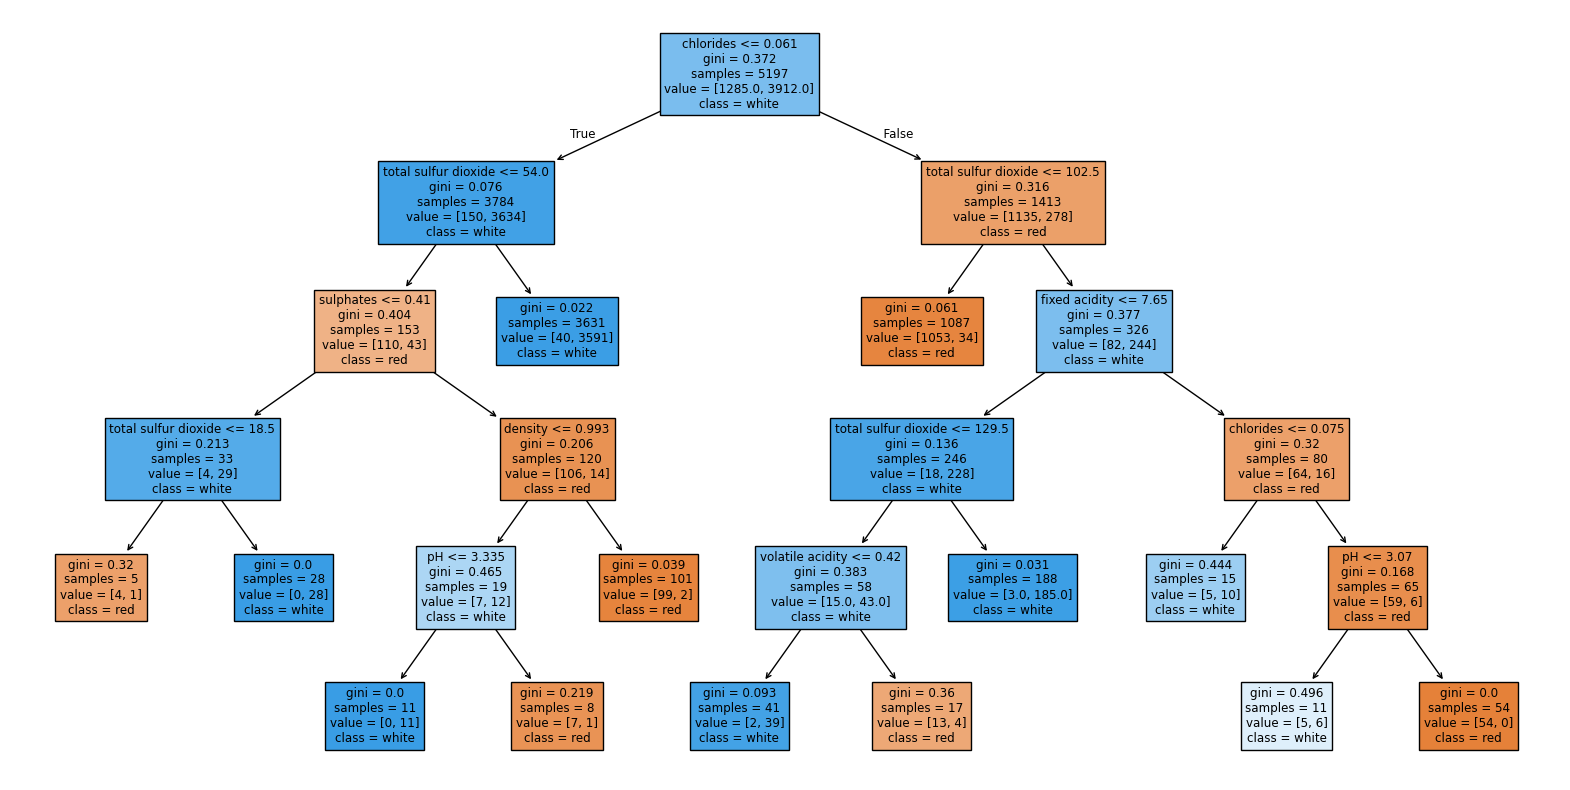

In [12]:
# Optimal Hyperparameters based on the previous plots
hyperparameters =  {
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'min_weight_fraction_leaf': 0.0,
    'max_features': 5,
    'max_leaf_nodes': 20,
    'min_impurity_decrease': 0.001
}

model = DecisionTreeClassifier(random_state=42, **hyperparameters).fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train))
test_score = accuracy_score(y_test, model.predict(X_test))

print(f"Train Accuracy: {train_score:.4f} --- Test Accuracy: {test_score:.4f}")

#Plot the tree
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=X.columns, class_names=['red', 'white'])
plt.show()

### Random Search

In [8]:
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_ranges,
    n_iter=200,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
print("Test accuracy:", random_search.score(X_test, y_test))

Best params: {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 10, 'min_samples_leaf': 20, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 10, 'max_features': None, 'max_depth': 15}
Best CV score: 0.978640704819723
Test accuracy: 0.9830769230769231


#### Conclusion

| Method          | Train Accuracy | Test Accuracy | CV Score |
|-----------------|----------------|---------------|----------|
| Baseline        | 0.9883         | 0.9831        | -        |
| Manual Tuning   | 0.9813         | 0.9862        | -        |
| Randomized Search | -            | 0.9831        | 0.9786   |

After running the randomized search we obtain a test accuracy of 0.9831 which is similar to the baseline model and lower than the manually tuned model. The CV score is also lower than the test accuracy which indicates that the model is overfitting slightly. Overall, the manually tuned model performs best on this dataset. Another possibility would be to use exhaustive search to try all combinations of hyperparameters to find the optimal set but this would be computationally expensive. I hypothesize that the random search did not find a better model because the search space was too large and the number of iterations was too low to find the optimal combination of hyperparameters.